# Get sorted spikes and bouts and make rasters/gpfa

For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts
- sort_raster_bout:
    - syncrhonization of nidaq/ap time events
    - spike sorting
    - labeling of sorted units for their corresponding nucleus
    - inspection of rasters
    
This notebook should not depend on the raw_data

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2022-10-23 14:46:34,045 root         INFO     Running on pakhi.ucsd.edu


In [3]:
from ceciestunepipe.file import bcistructure as et

#from ceciestunepipe.util import sglxutil as sglu
#from ceciestunepipe.util import sglxsync as sy

from ceciestunepipe.util import oeutil as oeu
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import fileutil as fu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
#from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
#from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

from ceciestunepipe.pipeline import searchbout as sb

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-10-23 14:47:07,858 root         INFO     all modules loaded


### Session parameters

In [4]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [5]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2022-08-17',
            
           'probe': 'probe_0',
           'sort': 'sort_0',
           'trial_tag_chan': 0, # what whas the tag channel in the stimulus wave (this should come from meta et. al)
            'on_signal': 1, # whether singnal on is hi or lo
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           'stim_sess': None, # if there was a stimulus epoch, where the stimuli were coming from
           'mic_chan': 0, # where the microphone is in the wav_mic.npy array
           'pre_chan': 0} # where the pressure is in the wav_adc.npy array


exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'], ephys_software='oe')

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['oe']

sess_epochs = oeu.list_oe_epochs(exp_struct)
sess_epochs

['2022-08-17_12-38-44_550']

In [6]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17',
  'oe': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe',
  'kwik': '/scratch/earneodo/s_b1555_22/oe/kwik/2022-08-17',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-08-17/oe',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe',
  'tmp': '/scratch/earneodo/tmp',
  'msort': '/scratch/earneodo/s_b1555_22/oe/msort/2022-08-17',
  'ksort': '/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/sort_0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe/rig.json',
  'kwd': '/scratch/earneodo/s_b1555_22/oe/kwik/2022-08-17/stream.kwd',
  'kwik': '

In [35]:
### pick a session, epoch
reload(et)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch, ephys_software='oe')


derived_folder = exp_struct['folders']['derived']

In [36]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17_12-38-44_550',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/2022-08-17_12-38-44_550',
  'oe': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550',
  'kwik': '/scratch/earneodo/s_b1555_22/oe/kwik/2022-08-17/2022-08-17_12-38-44_550',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550',
  'tmp': '/scratch/earneodo/tmp/2022-08-17_12-38-44_550',
  'msort': '/scratch/earneodo/s_b1555_22/oe/msort/2022-08-17/2022-08-17_12-38-44_550',
  'ksort': '/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/2022-08-17_12-38-44_550/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/sort_0'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/2022-08-17_12-38-44_550

In [37]:
derived_folder

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550'

In [11]:
!ls /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550

bout_1_gpfa_sua.eps  bout_pd_oeb.pkl  mot_dict_oeb.pkl	spk_df.pkl
bout_1_gpfa_sua.png  bout_pd_oe.pkl   mot_dict.pkl	wav_mic.wav
bout_dict_oe.pkl     clu_df.pkl       sort_0


### load epoch files

In [34]:
exp_struct['folders']['derived']

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550'

In [12]:
### get the spikes df, clu df, bouts and syncrhonization files

## the sort
sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])

logger.info('Loading sort files from ' + sort_folder)

clu_df_path = os.path.join(sort_folder, 'clu_df.pkl')
clu_df = pd.read_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pkl')
spk_df = pd.read_pickle(spk_df_path)


## the bout/stim
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict_oe.pkl')
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_pd_oe.pkl')

logger.info('loading synced bout and dict and pandas dataframe from {}, {}'.format(bout_dict_path, bout_df_path))
with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
bout_df = pd.read_pickle(bout_df_path)


#load the mic, pressure if any
mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.wav')

s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'], sess_par['mic_chan'])
#s_f_wav, pre_stream = wu.read_wav_chan(adc_path, sess_par['pre_chan'])

ap_sf = bout_dict['s_f_ap_0']

2022-10-23 15:03:35,395 root         INFO     Loading sort files from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/sort_0
2022-10-23 15:03:37,357 root         INFO     loading synced bout and dict and pandas dataframe from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_dict_oe.pkl, /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_pd_oe.pkl


In [13]:
bout_dict_path

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_dict_oe.pkl'

In [14]:
spk_df.head(1)

,times,clusters,cluster_id,nucelus,main_chan,kslabel
0,427,38,38,NaN,25,mua


In [15]:
clu_df.head(1)

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,...,isi_hist,violation_fraction,is_good,main_waveform,height,left_mh_x,right_mh_x,mh_width,mean_fr,mh_width_ms
0,10,5259.8,100.0,mua,144.193878,12,20.0,1.434807,good,17672,...,"([507, 515, 440, 437, 465, 488, 557, 612, 639,...",0.028689,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.566134,38,41,3,1.434807,90.0


In [16]:
# #load the mic, pressure if any
# mic_path = os.path.join(exp_struct['folders']['derived'], 'wav_mic.npy')
# adc_path = os.path.join(exp_struct['folders']['derived'], 'wav_adc.npy')

# mic_stream = np.memmap(adc_path)

In [17]:
bout_df.keys()

Index(['start_ms', 'end_ms', 'start_sample', 'end_sample', 'p_step', 'rms_p',
       'peak_p', 'bout_check', 'file', 'len_ms', 'syl_in', 'n_syl', 'peaks_p',
       'n_peaks', 'l_p_ratio', 'waveform', 'confusing', 'valid_waveform',
       'valid', 'spectrogram', 'is_call', 'bird', 'sess', 'epoch',
       'start_sample_ap_0', 'start_sample_naive', 'start_ms_ap_0'],
      dtype='object')

In [18]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0'])

### Visualize a bout together with the neural traces

In [19]:
plt.rcParams['lines.linewidth'] = 0.1

In [20]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

### collect all the bouts

In [21]:
bout_dict

{'s_f': 30000,
 's_f_nidq': 30000.0,
 's_f_ap_0': 30000.0,
 'start_ms': array([ 7396079,  9588469,  7482809,  8699234,  6309826,  6039071,
        10005551,  6188841,  8028629,  6683961,  6573616,  7173531,
         9159904,  7890864,  7048151,  6754641,  7266466, 11610796,
         7670599,  5958646,  4528748,  6481841,  7724489, 10549866,
         9347599,  7965044,  6977746,  7785329,  9948701, 11550281,
         5907571, 11303986,  7858574,  7106146,  5859571,  7617004,
         6631636,  5791111,  7158706, 11530976,  8245669,  8676424,
         6743616,  8268184,  8918739,  7038141,  7647009,  6969811,
         5834666,  7149326,  6676751,  8667909,  7349131,  6303031]),
 'len_ms': array([55615, 52120, 51495, 50660, 50430, 43845, 43745, 41935, 41795,
        41790, 41420, 40005, 38590, 37855, 37710, 37515, 37150, 36970,
        36345, 36200, 35725, 35685, 35005, 34360, 34140, 33975, 32310,
        31995, 31885, 31805, 30200, 28755, 25895, 25370, 24985, 24310,
        22595, 21885,

In [22]:
bout_dict.keys()

dict_keys(['s_f', 's_f_nidq', 's_f_ap_0', 'start_ms', 'len_ms', 'start_sample_naive', 'start_sample_nidq', 'start_sample_wav', 'start_ms_ap_0', 'start_sample_ap_0'])

In [23]:
def collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, pre_stream=None, t_pre=-2, t_post=2):
    # get t_pre, t_post in samples for wav, ap
    # tet start_end samples for each
    # collect the spikes
    # collect the streams
    bout_dict['t_pre'] = t_pre
    bout_dict['t_post'] = t_post
    
    sf_ap = bout_dict['s_f_ap_0']
    sf = bout_dict['s_f']
    
    pre_ap, post_ap = [int(x * sf_ap) for x in [t_pre, t_post]]
    pre_wav, post_wav = [int(x * sf) for x in [t_pre, t_post]]
    
    bout_df['len_sample_ap_0'] = (bout_df['len_ms'] * sf_ap * 0.001).astype(int)
    bout_df['end_sample_ap_0'] = bout_df['start_sample_ap_0'] + bout_df['len_sample_ap_0']

    bout_df['spk_arr'] = bout_df.apply(lambda x: ks.get_window_spikes(spk_df, clu_list, 
                                                                      x['start_sample_ap_0'] + pre_ap, 
                                                                      x['end_sample_ap_0'] + post_ap), 
                                       axis=1)

    bout_df['mic_arr'] = bout_df.apply(lambda x: mic_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav], 
                                       axis=1)
    if pre_stream is not None:
        bout_df['pre_arr'] = bout_df.apply(lambda x: pre_stream[x['start_sample']+pre_wav: x['end_sample']+post_wav],
                                           axis=1)
    else:
        bout_df['pre_arr'] = bout_df['mic_arr']
    
    # while we are at it, compute the spectrograms (ms scale)
    bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), sf))
    
    # split the spectrogram to be able to work with hdf5 save/load.
    # don't want to be saving tuples, rather arrays
    bout_df[['f_xx', 't_xx', 's_xx']] = pd.DataFrame(bout_df['sxx'].tolist(), index=bout_df.index)
    
    bout_df['clu_id_arr'] = [clu_list for x in bout_df.index]
    
    return bout_df

In [24]:
### one spk_arr
# mot_idx = 0

# start_ap = bout_df.loc[mot_idx, 'start_sample_ap_0']
# end_ap = bout_df.loc[mot_idx, 'end_sample_ap_0']

# spk_arr = ks.get_window_spikes(spk_df, clu_list, start_ap - 60000 , end_ap+60000)

In [25]:
clu_list = np.unique(clu_df.loc[(clu_df['MSLabel'].isin(['good', 'mua'])) & (clu_df['nucleus'].isin(['hvc'])), 
                                'cluster_id'])
clu_list

array([ 1,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20,
       21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 70, 72, 73])

In [26]:
t_pre = - 5
t_post = 5

bout_df = collect_bouts_df(bout_df, bout_dict, spk_df, clu_list, mic_stream, None, 
                           t_pre=t_pre, t_post=t_post)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:110: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [27]:
bout_df.index.size

54

##### sanity check, plot one of the bout-rasters

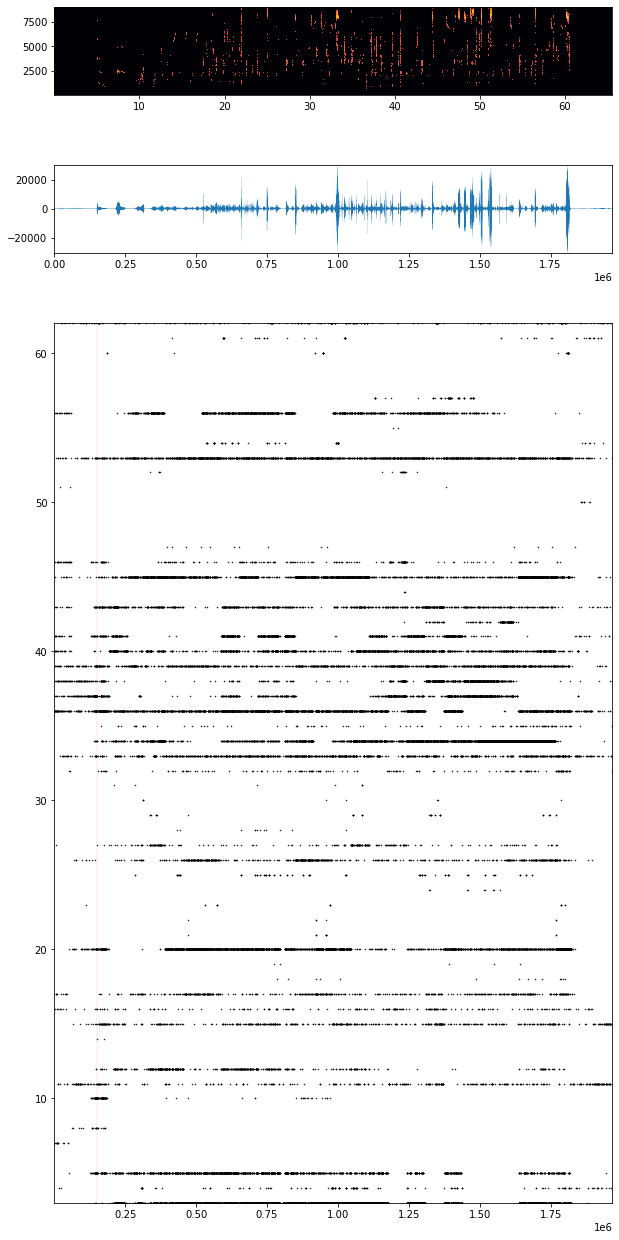

In [28]:
def plot_bout(bout_series, bout_dict):
    # get the raster, the spectrogram and the pressure
    
    t_pre = bout_dict['t_pre']
    s_f_ap = bout_dict['s_f_ap_0']
    s_f = bout_dict['s_f']
    
    mic_arr = bout_series['mic_arr']
    pre_arr = bout_series['pre_arr']
    spk_arr = bout_series['spk_arr']
    # plot
    
    fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

    f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f)

    #ax[0].plot(mic_arr.flatten())
    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
    ax[1].plot(pre_arr.flatten());
    pu.plot_as_raster(spk_arr, t_0=int(-t_pre*s_f_ap), ax=ax[2])
    
plot_bout(bout_df.iloc[0], bout_dict)

<AxesSubplot:>

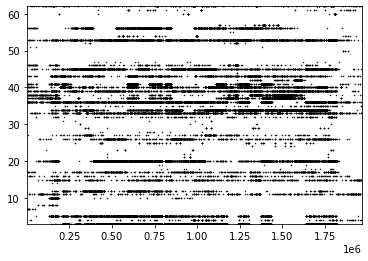

In [29]:
pu.plot_as_raster(bout_df.iloc[0]['spk_arr'])

### get all the gpfa

In [30]:
import neo
import quantities as pq
from elephant.gpfa import GPFA
import viziphant as vp

Elephant wants nested lists of SpikeTrain objects.
[n_trials, n_spiketrains, n_spikes] (each spike is a time where a spike occurred)

The strategy is to do all the spiketrains, do the fit, then project each array and store that in the pandas dataframe bout_df

In [31]:
def spike_trains_from_spk_arr(spk_arr, s_f=30000):
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

In [32]:
bout_df['spk_train'] = bout_df['spk_arr'].apply(lambda x: spike_trains_from_spk_arr(x, bout_dict['s_f_ap_0']))

In [33]:
all_spk_train_list = list(bout_df['spk_train'])

In [95]:
# specify fitting parameters
bin_size = 15 * pq.ms
latent_dimensionality = 8

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [96]:
## fit and project
all_spk_train_list = list(bout_df['spk_train'])
all_fit_list = gpfa_2dim.fit_transform(list(bout_df['spk_train']))
bout_df['spk_gpf'] = all_fit_list

print(gpfa_2dim.params_estimated.keys())

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...


/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 4 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes', 'Corth'])


In [97]:
### project 
#all_fit_list = gpfa_2dim.transform(all_spk_train_list)

In [98]:
#### plot some

In [99]:
### a better spectrogram
def kozlov_averaging(spec, n_rows=2, n_cols=3):
    '''
    Average rows and columns of spectrogram according to Kozlov & Gentner 2016 
    In Andrei's paper he averaged twice along rows(frequency bins) and three times
    across columns (time bins).
    n_rows specifies how many times to average rows pairwise, and n_cols specifies how many times
    to average columsn pairwise.
    '''
    spec_c = np.copy(spec)

    for idx in range(n_rows):
        spec_c = avg_pairwise(spec_c, axis=0)

    for idx in range(n_cols):
        spec_c = avg_pairwise(spec_c, axis=1)

    return spec_c

def ms_spectrogram(x, s_f, n_window=512, step_ms=1, f_min=0, f_max=20000, 
                     ref_db=20, min_db=-30, avg_func=None):
    
    ### spectrogram
    f, t, sxx = sp.ms_spectrogram(x, s_f, n_window=n_window, step_ms=step_ms, 
                                  f_min=f_min, f_max=f_max, cut_off=0)
    
    spec = 10*np.log10(np.maximum(1e-5, sxx[1:, :])) - ref_db
    f = f[1:]
    
    # average, if specified
    if avg_func is not None:
        spec = avg_func(spec)

    # normalize
    spec = np.clip((spec - min_db) / (-1.0*min_db), 0, 1)
    
    spec[spec==np.nan] = 1
    return f, t, spec

bout_df['sxx'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), bout_dict['s_f']))

In [100]:
#### get the PC of the spectrogram.

## cat all spectrogram to make a fit
## project each pc

from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')

all_x = np.hstack(bout_df['sxx'].apply(lambda x: x[2]))
all_x[all_x==np.nan] = 1 ### better do a zscore

# fit all
pca.fit(np.log(all_x.T))

# project all
bout_df['sxx_pc'] = bout_df['sxx'].apply(lambda x: pca.transform(np.log(x[2].T)))

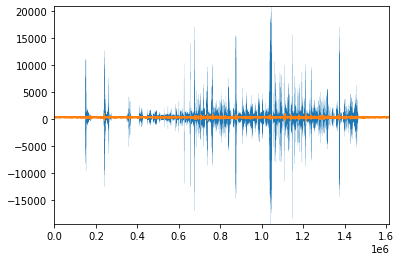

In [101]:
###filter the presure
import scipy
b, a = scipy.signal.butter(4, 1000, 'lp', fs=bout_dict['s_f'], output='ba')

bout_df['pre_filt'] = bout_df['pre_arr'].apply(lambda x: signal.filtfilt(b, a, x))

plt.plot(bout_df.iloc[5]['pre_arr'])
plt.plot(bout_df.iloc[5]['pre_filt'], lw=1)

In [102]:
%matplotlib inline

In [38]:
### se them together all for a bout now
def plot_bout_projections(bout_series):
    sxx_pc = bout_series['sxx_pc']
    gpf = bout_series['spk_gpf']
    pre_arr = bout_series['pre_filt']
    mic_arr = bout_series['mic_arr']
    
    f, t, sxx = bout_series['sxx']
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8));

    ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno', rasterized=True)
    ax[0].set_xlabel('t (s)')
    
    ax[1].plot((np.abs(mic_arr)), 'k');
    ax[1].set_ylabel('sound amplitude (arb)')

    ax[2].set_title('spectrogram PC')
    ax[2].plot(sxx_pc, lw=1);

    ax[3].set_title('HVC GPFA');
    ax[3].plot(gpf[:3].T, lw=1);

    ax[4].set_title('sound pressure');
    ax[4].plot(pre_arr, lw=1);
    
    for ax_i in ax[1:]:
        ax_i.set_xticks([])
        ax_i.set_yticks([])
    
    return ax


ax = plot_bout_projections(bout_df.iloc[35])

KeyError: 'sxx_pc'

In [115]:
fig = ax[0].get_figure()
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_gpfa_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')
logger.info('saved figures in ' + fig_path)

2022-08-30 14:14:27,140 root         INFO     saved figures in /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_1_gpfa_sua


In [36]:
%matplotlib notebook

In [37]:
#bout_df.to_hdf(bout_df_path, 'gpfa')

In [38]:
### bring it dask because shit got big

In [ ]:
bout_df['p_step'].values.shape

In [ ]:
bout_df['s_xx'].values[2].shape

In [ ]:
bout_df.loc[0]

In [ ]:
bout_df.keys()

In [ ]:
bout_dict.keys()

In [116]:
import h5py
from ceciestunepipe.util import h5util as h5u

In [117]:
def bouts_to_h5(bout_df: pd.DataFrame, bout_dict: dict, dset_keys: list, attr_keys: list, bout_dict_keys: list, 
                h5_path: str,
               root_grp_name: str='bout_gpfa'):
    
    # make a h5 file.
    # create a group for the dataframe
    # append the bout metada dict keys to the group
    # for each row (bout)
        # create a group with the index of the bout
        # apend attr_keys with values for the bout as attributes (mostly scalars)
        # create datasets for all the long arrays that contain data over time

    with h5py.File(bout_df_path,'w') as f:
        df_grp = f.create_group(root_grp_name)
        grp_attr_dict = {k:bout_dict[k] for k in bout_dict_keys}
        h5u.append_atrributes(df_grp, grp_attr_dict)
        #dset_keys = ['mic_arr', 'pre_arr']
        
        for idx, row in bout_df.iterrows():
            bout_grp = df_grp.create_group(str(idx))
            [bout_grp.create_dataset(k, data=row[k]) for k in dset_keys]

            bout_attr_dict = {k:row[k] for k in attr_keys}
            h5u.append_atrributes(bout_grp, bout_attr_dict)
            

In [120]:
bout_df.keys()

Index(['start_ms', 'end_ms', 'start_sample', 'end_sample', 'p_step', 'rms_p',
       'peak_p', 'bout_check', 'file', 'len_ms', 'syl_in', 'n_syl', 'peaks_p',
       'n_peaks', 'l_p_ratio', 'waveform', 'confusing', 'valid_waveform',
       'valid', 'spectrogram', 'is_call', 'bird', 'sess', 'epoch',
       'start_sample_ap_0', 'len_sample_ap_0', 'end_sample_ap_0', 'spk_arr',
       'mic_arr', 'sxx', 'f_xx', 't_xx', 's_xx', 'clu_id_arr', 'pre_arr',
       'spk_train', 'spk_gpf', 'sxx_pc', 'pre_filt'],
      dtype='object')

In [124]:
attr_keys = ['start_ms', 'end_ms', 'len_ms', 
             'start_sample', 'end_sample',
             'start_ms_ap_0', 'start_sample_ap_0',
             'start_sample_naive', 'len_sample_ap_0', 'end_sample_ap_0',
             'bout_check', 'confusing', 'file']

dset_keys = ['mic_arr', 'pre_arr', 'pre_filt', 'syl_in',
             'f_xx', 't_xx', 's_xx', 'sxx_pc', 
             'spk_arr', 'spk_gpf']

dict_keys = ['s_f', 's_f_nidq', 's_f_ap_0', 't_pre', 't_post']


logger.info('Saving the gpfa, pca results onto an hdf5 file {}'.format(bout_df_path))
bouts_to_h5(bout_df, bout_dict, dset_keys, attr_keys, dict_keys, bout_df_path)
logger.info('done')

2022-09-01 11:09:47,518 root         INFO     Saving the gpfa, pca results onto an hdf5 file /mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_df_gpfa.h5
2022-09-01 11:10:37,236 root         INFO     done
